In [1]:
from src.data.data_loader import get_dataloaders
from src.utils.seed import set_seed

In [2]:
set_seed(42)

In [3]:
train_loader, val_loader, test_loader = get_dataloaders(
    batch_size=32,
    num_workers=4
)

In [4]:
images, labels = next(iter(train_loader))

print(images.shape)  # [B, 3, H, W]
print(labels.shape)  # [B]

/Users/sreeram/Developer/Personal/paper-replications/vision-transformer-from-scratch/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


torch.Size([32, 3, 224, 224])
torch.Size([32])


In [5]:
import random 
import matplotlib.pyplot as plt 

dataset = train_loader.dataset

if hasattr(dataset, "dataset"):
    dataset = dataset.dataset 

class_names = dataset.classes
num_classes = len(class_names)

print(f"Total number of classes: {num_classes}")
print(f"Class names: {class_names}")

Total number of classes: 37
Class names: ['Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle', 'Bengal', 'Birman', 'Bombay', 'Boxer', 'British Shorthair', 'Chihuahua', 'Egyptian Mau', 'English Cocker Spaniel', 'English Setter', 'German Shorthaired', 'Great Pyrenees', 'Havanese', 'Japanese Chin', 'Keeshond', 'Leonberger', 'Maine Coon', 'Miniature Pinscher', 'Newfoundland', 'Persian', 'Pomeranian', 'Pug', 'Ragdoll', 'Russian Blue', 'Saint Bernard', 'Samoyed', 'Scottish Terrier', 'Shiba Inu', 'Siamese', 'Sphynx', 'Staffordshire Bull Terrier', 'Wheaten Terrier', 'Yorkshire Terrier']


In [6]:
class_samples = {}

indices = list(range(len(dataset)))
random.shuffle(indices)

for idx in indices:
    img, label = dataset[idx]
    if label not in class_samples:
        class_samples[label] = img
    
    if len(class_samples) == num_classes:
        break


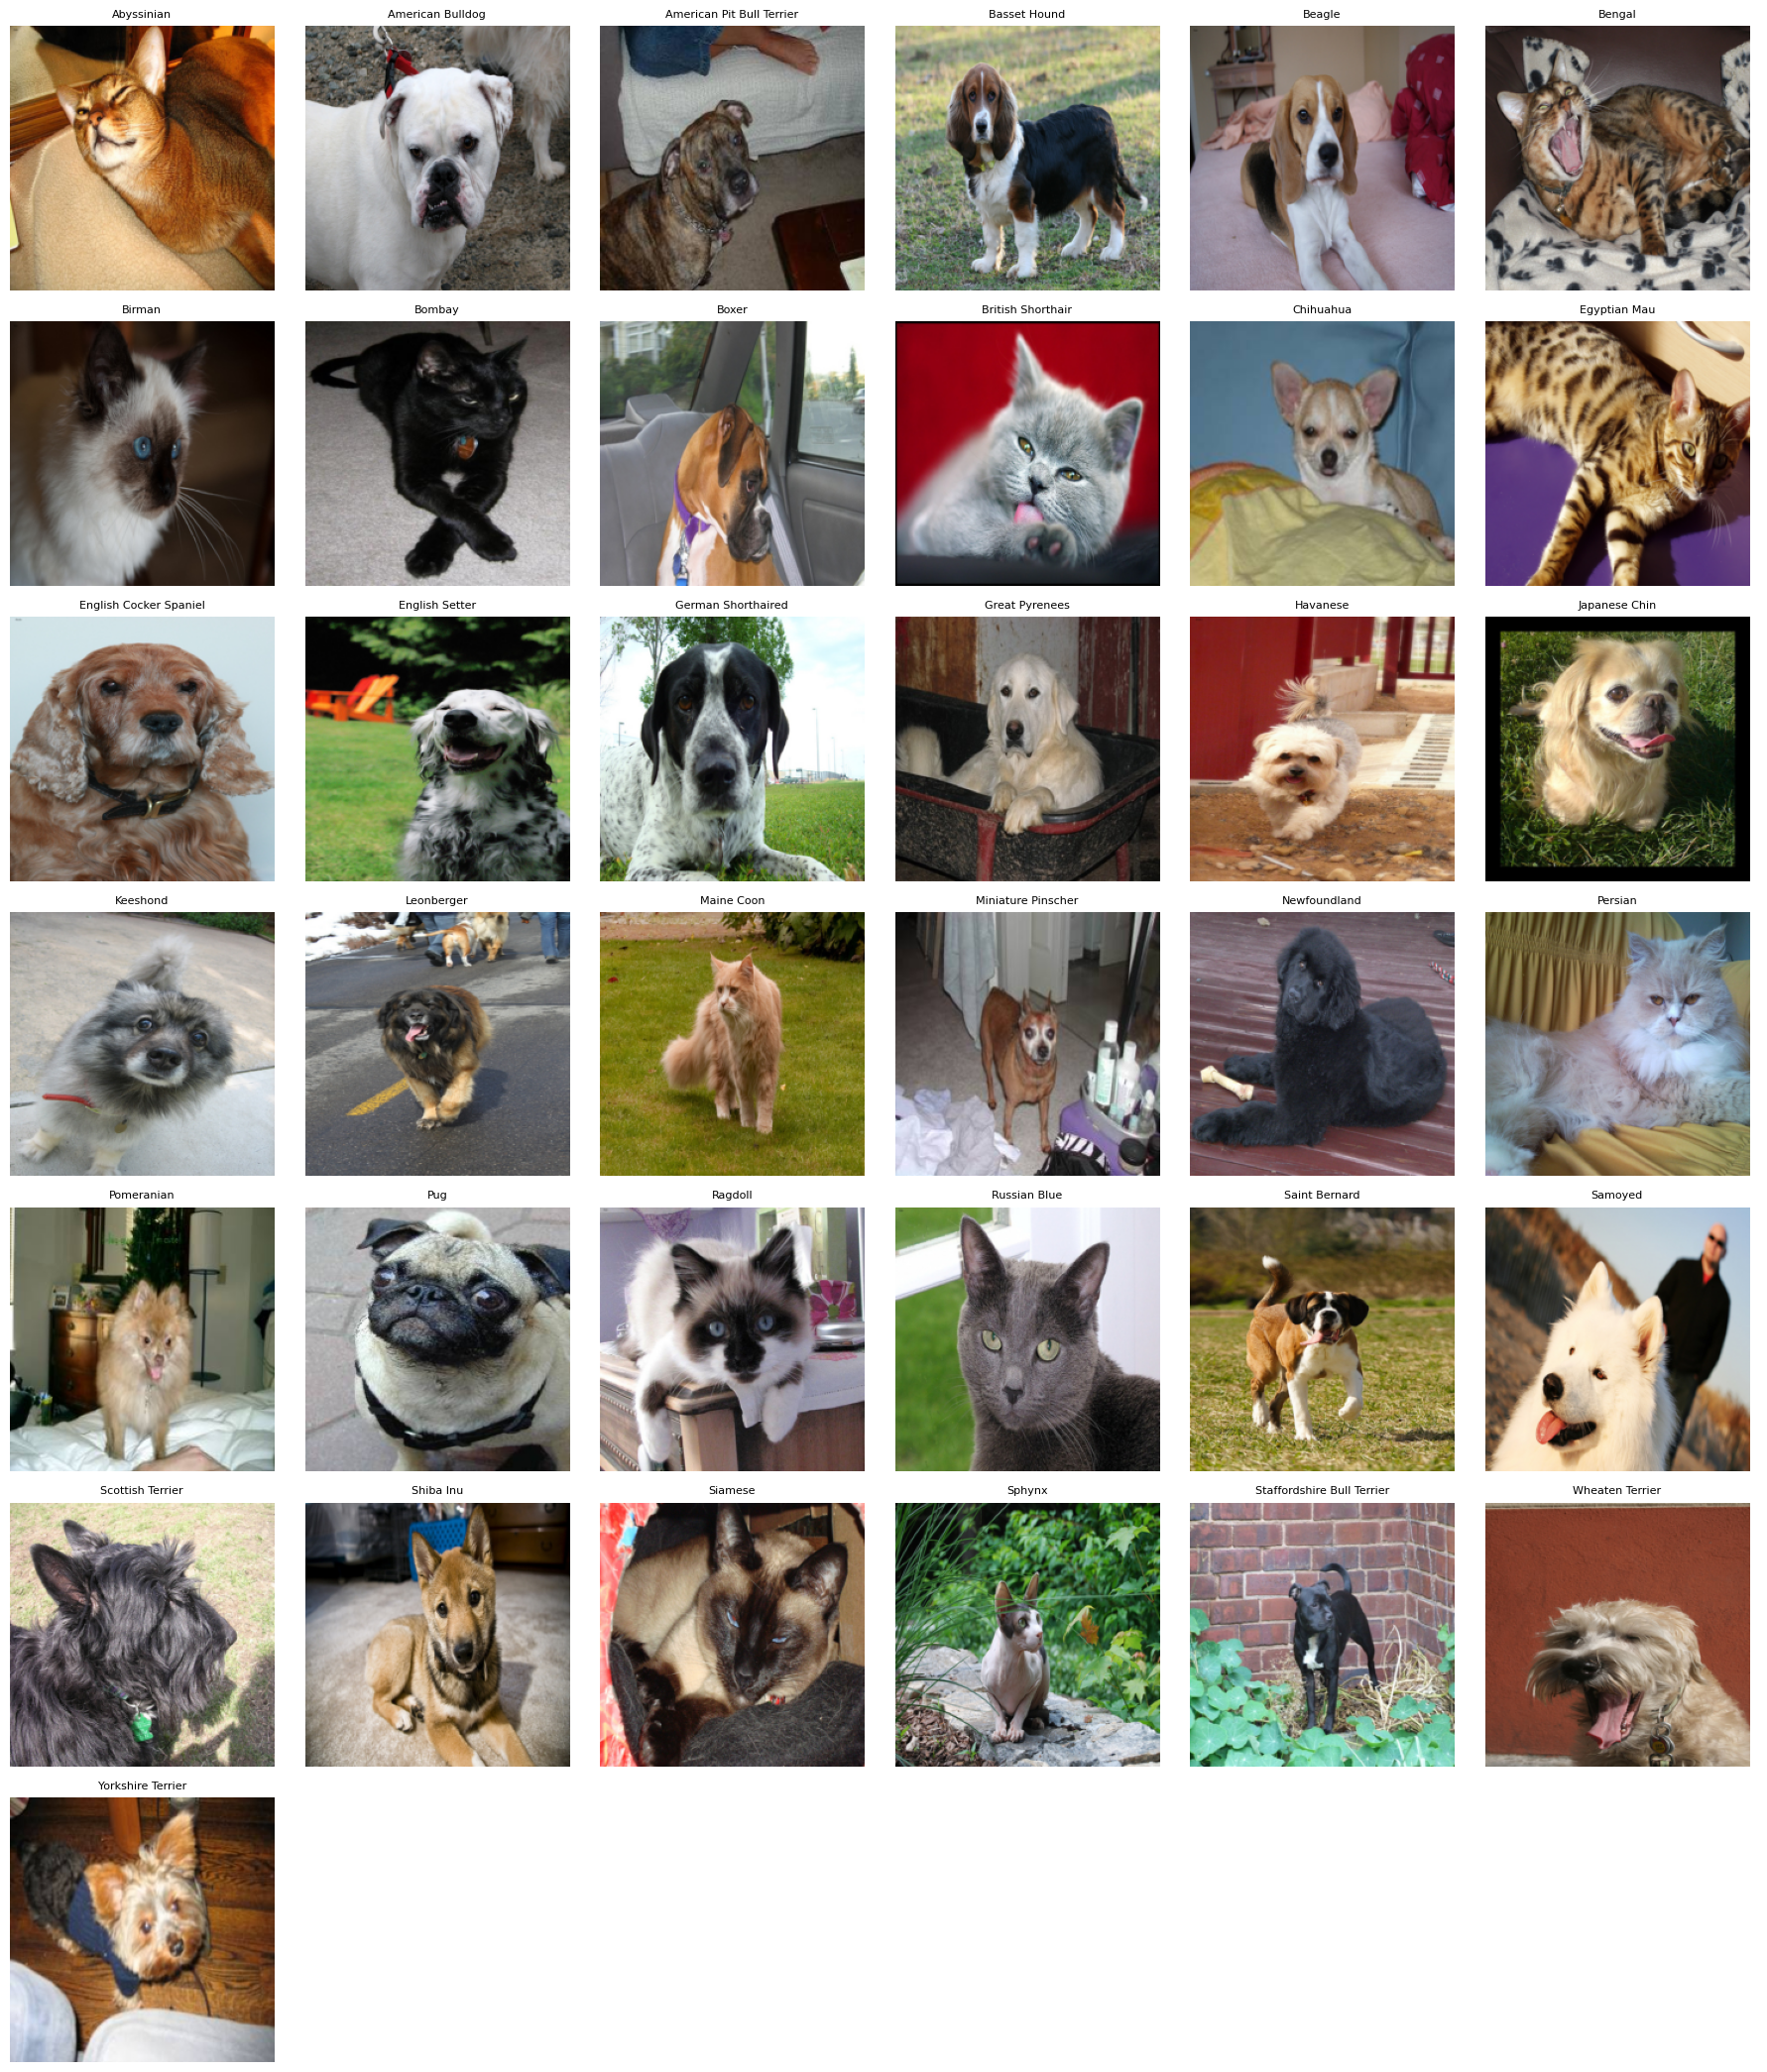

In [7]:
cols = 6
rows = (num_classes + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 3))
axes = axes.flatten()

for i, (label, img) in enumerate(sorted(class_samples.items())):
    axes[i].imshow(img.permute(1, 2, 0))
    axes[i].set_title(class_names[label], fontsize=8)
    axes[i].axis("off")

# Turn off extra empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [8]:
# Hyperparameters 

height = 224 # H 
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P


In [9]:
# Get a batch of images
image_batch, label_batch = next(iter(train_loader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

/Users/sreeram/Developer/Personal/paper-replications/vision-transformer-from-scratch/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


(torch.Size([3, 224, 224]), tensor(20))

In [10]:
from torch import nn 

flattner = nn.Flatten() 

image_2 = flattner(image.unsqueeze(dim=0))


print(image.shape)
image_2.shape


torch.Size([3, 224, 224])


torch.Size([1, 150528])

In [11]:

import importlib
import src.data.preprocessing as preprocessing
importlib.reload(preprocessing)

PatchEmbedding = preprocessing.PatchEmbedding


In [12]:
# Patch and preprocess image


patchify = PatchEmbedding(in_channels=3,patch_size=16,embedding_dim=768)

print(f"Input image shape: {image.unsqueeze(0).shape}")
patched_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding shape: {patched_embedded_image.shape}")


Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [13]:
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [14]:
batch_size = patched_embedded_image.shape[0]
embedding_dimension = patched_embedded_image.shape[-1]

In [15]:
import torch 
from torch import nn

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [16]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patched_embedded_image),
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0791,  0.0693,  0.2037,  ..., -0.0206, -0.2520,  0.0596],
         [-0.0195,  0.1880,  0.1665,  ..., -0.0584, -0.1535,  0.0376],
         ...,
         [-0.0112,  0.3412,  0.2476,  ..., -0.0922, -0.2510,  0.0785],
         [ 0.0092,  0.3049,  0.2678,  ..., -0.0856, -0.2511,  0.0741],
         [ 0.0608,  0.3294,  0.2828,  ..., -0.0851, -0.2380,  0.0747]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [17]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.0791,  0.0693,  0.2037,  ..., -0.0206, -0.2520,  0.0596],
          [-0.0195,  0.1880,  0.1665,  ..., -0.0584, -0.1535,  0.0376],
          ...,
          [-0.0112,  0.3412,  0.2476,  ..., -0.0922, -0.2510,  0.0785],
          [ 0.0092,  0.3049,  0.2678,  ..., -0.0856, -0.2511,  0.0741],
          [ 0.0608,  0.3294,  0.2828,  ..., -0.0851, -0.2380,  0.0747]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [18]:

number_of_patches = int((height * width) / patch_size**2)

embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]


position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) 

print(position_embedding[:, :10, :10])
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [19]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")


tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9209, 1.0693, 1.2037,  ..., 0.9794, 0.7480, 1.0596],
         [0.9805, 1.1880, 1.1665,  ..., 0.9416, 0.8465, 1.0376],
         ...,
         [0.9888, 1.3412, 1.2476,  ..., 0.9078, 0.7490, 1.0785],
         [1.0092, 1.3049, 1.2678,  ..., 0.9144, 0.7489, 1.0741],
         [1.0608, 1.3294, 1.2828,  ..., 0.9149, 0.7620, 1.0747]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [20]:
import importlib
import importlib
import src.models.vit as vit_module  # import the module itself

importlib.reload(vit_module)

VisionTransformer = vit_module.VisionTransformer  # rebind class
vit_model = VisionTransformer()

In [21]:
import torch

from src.models.vit import VisionTransformer

vit_model = VisionTransformer()

In [22]:
set_seed()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = VisionTransformer()

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[ 0.2093,  1.0928,  1.4915, -0.3573, -0.5675,  0.3727,  0.2003, -0.0073,
         -0.3410,  0.3545,  0.6161,  0.2791, -0.4173, -0.4105, -0.9089, -0.5160,
         -0.4683, -0.7166,  0.3869,  0.3506,  0.0502,  0.9510,  0.0052, -0.3316,
          0.3608, -0.1873,  0.5508,  0.1021, -0.5472, -0.2707,  0.2471,  0.4977,
          0.7253,  0.5448,  0.1982, -0.3460, -0.4113]],
       grad_fn=<AddmmBackward0>)

In [23]:
from src.engine import trainer 



/Users/sreeram/Developer/Personal/paper-replications/vision-transformer-from-scratch/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
import src.engine as engine_module  # import the module itself

importlib.reload(engine_module)


<module 'src.engine' from '/Users/sreeram/Developer/Personal/paper-replications/vision-transformer-from-scratch/src/engine/__init__.py'>

In [25]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using CUDA: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon MPS")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using Apple Silicon MPS


In [26]:
NUM_EPOCHS = 5
BATCH_SIZE = 32
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001

In [27]:
import torch 

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit_model.parameters(),
                             lr=LEARNING_RATE)

In [28]:

vit_model = vit_model.to(device)


In [29]:
trainer.train(model=vit_model,
             train_loader=train_loader,
             test_loader=test_loader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=NUM_EPOCHS,
             device=device)

Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]/Users/sreeram/Developer/Personal/paper-replications/vision-transformer-from-scratch/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Training Progress:   0%|          | 0/5 [00:27<?, ?it/s]


KeyboardInterrupt: 